# 🔬 GNN Architectures Deep Dive

This is the first notebook for the GNN learning with movie dataset. In this notebook our aim is to see the big picture and understand the shapes of the data.

## Understanding Layer-by-Layer with Shapes

This notebook explains GNN architectures with input/output shapes at every layer.

We will see how the data is transferred through GNN architecture. What are the shapes of the data in each layer? What do we achieve?

---

## 🎯 The Big Picture: What Are We Computing?

### The Two-Stage Process

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                                                                             │
│   STAGE 1: Learn Embeddings              STAGE 2: Predict Ratings           │
│   ─────────────────────────              ────────────────────────           │
│                                                                             │
│   ┌─────────────┐                        ┌─────────────────────────┐        │
│   │   Graph     │                        │  User Embedding (64,)   │        │
│   │   (Users +  │ ───► GNN Layers ───►   │          ×              │ ───► Rating (scalar)  │
│   │   Movies)   │                        │  Movie Embedding (64,)  │        │
│   └─────────────┘                        └─────────────────────────┘        │
│                                                                             │
│   Output: Embeddings for ALL             Output: Single rating              │
│   users and movies                       for one (user, movie) pair         │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

### The GNN outputs embeddings, then we use those embeddings to predict ratings.

1. **GNN Output**: Embeddings for EVERY user and EVERY movie
2. **Final Prediction**: Dot product of (user_embedding, movie_embedding) → rating

---

## 📐 Let's Define Our Example Dimensions

For all examples in this notebook, we'll use:

| Parameter | Value | Description |
|-----------|-------|-------------|
| `num_users` | 610 | Number of users |
| `num_movies` | 9,724 | Number of movies |
| `num_nodes` | 10,334 | Total nodes (users + movies) |
| `num_edges` | 100,836 | Number of ratings (edges) |
| `embedding_dim` | 64 | Size of each embedding vector |
| `num_layers` | 3 | Number of GNN layers |

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import warnings
warnings.filterwarnings('ignore')

# Our example dimensions
NUM_USERS = 610
NUM_MOVIES = 9724
NUM_NODES = NUM_USERS + NUM_MOVIES  # 10,334
NUM_EDGES = 100836
EMBEDDING_DIM = 64
NUM_LAYERS = 3

print("Example Dimensions:")
print(f"  Users: {NUM_USERS}")
print(f"  Movies: {NUM_MOVIES}")
print(f"  Total Nodes: {NUM_NODES}")
print(f"  Edges (ratings): {NUM_EDGES}")
print(f"  Embedding Dimension: {EMBEDDING_DIM}")

Example Dimensions:
  Users: 610
  Movies: 9724
  Total Nodes: 10334
  Edges (ratings): 100836
  Embedding Dimension: 64


---

## 📊 Part 1: Input Data Shapes

Before we look at the networks, let's understand the input data:

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                           INPUT DATA STRUCTURES                             │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. Node Features (X)                                                       │
│     Shape: (num_nodes, feature_dim) = (10334, 64)                          │
│                                                                             │
│     ┌──────────────────────────────────────────┐                           │
│     │  User 0:    [0.1, 0.3, ..., 0.2]  (64,)  │                           │
│     │  User 1:    [0.4, 0.1, ..., 0.5]  (64,)  │                           │
│     │  ...                                     │                           │
│     │  User 609:  [0.2, 0.8, ..., 0.1]  (64,)  │                           │
│     │  ─────────────────────────────────────── │                           │
│     │  Movie 0:   [0.5, 0.2, ..., 0.3]  (64,)  │                           │
│     │  Movie 1:   [0.1, 0.9, ..., 0.4]  (64,)  │                           │
│     │  ...                                     │                           │
│     │  Movie 9723:[0.3, 0.1, ..., 0.7]  (64,)  │                           │
│     └──────────────────────────────────────────┘                           │
│                                                                             │
│  2. Edge Index                                                              │
│     Shape: (2, num_edges * 2) = (2, 201672)                                │
│     (We double edges for bidirectional message passing)                    │
│                                                                             │
│     ┌─────────────────────────────────────────────┐                        │
│     │  Source: [0,    0,    1,    1,    ...]      │ ← Which node sends     │
│     │  Target: [610,  725,  610,  892,  ...]      │ ← Which node receives  │
│     └─────────────────────────────────────────────┘                        │
│     Meaning: User 0 rated Movie 0 (idx 610), Movie 115 (idx 725), etc.    │
│                                                                             │
│  3. Edge Attributes (Optional)                                             │
│     Shape: (num_edges * 2,) = (201672,)                                    │
│     Contains: Rating values [4.5, 3.0, 5.0, ...]                           │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

In [3]:
# Create example tensors to show shapes
print("=" * 60)
print("INPUT DATA SHAPES")
print("=" * 60)

# Node features
X = torch.randn(NUM_NODES, EMBEDDING_DIM)
print(f"\n1. Node Features (X) include both user and movie:")
print(f"   Shape: {X.shape}")
print(f"   Meaning: {NUM_NODES} nodes, each with {EMBEDDING_DIM}-dimensional features")
print(f"   Memory: {X.numel() * 4 / 1024:.1f} KB (float32)")

# Edge index (bidirectional)
edge_index = torch.randint(0, NUM_NODES, (2, NUM_EDGES * 2))
print(f"\n2. Edge Index created by torch.randint :")
print(f"   Shape: {edge_index.shape}")
print(f"   Meaning: {NUM_EDGES * 2} directed edges (bidirectional)")
print(f"   Row 0 = source nodes, Row 1 = target nodes")

# Edge attributes
edge_attr = torch.randn(NUM_EDGES * 2)
print(f"\n3. Edge Attributes (ratings): created by torch.randn")
print(f"   Shape: {edge_attr.shape}")
print(f"   Meaning: One rating value per edge")

INPUT DATA SHAPES

1. Node Features (X) include both user and movie:
   Shape: torch.Size([10334, 64])
   Meaning: 10334 nodes, each with 64-dimensional features
   Memory: 2583.5 KB (float32)

2. Edge Index created by torch.randint :
   Shape: torch.Size([2, 201672])
   Meaning: 201672 directed edges (bidirectional)
   Row 0 = source nodes, Row 1 = target nodes

3. Edge Attributes (ratings): created by torch.randn
   Shape: torch.Size([201672])
   Meaning: One rating value per edge


---

## 🧱 Part 2: Matrix Factorization (Baseline)

First, let's understand Matrix Factorization as a baseline - this is what your current system uses.

### Architecture Diagram

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                    MATRIX FACTORIZATION ARCHITECTURE                        │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  INPUT                           EMBEDDINGS                    OUTPUT       │
│  ─────                           ──────────                    ──────       │
│                                                                             │
│  user_id ──► ┌──────────────────┐                                          │
│    (1,)      │ User Embedding   │ ──► user_emb ──┐                         │
│              │ (610, 64)        │      (64,)     │                         │
│              └──────────────────┘                │    ┌─────────┐          │
│                                                  ├──► │ Dot     │ ──► rating │
│  movie_id ─► ┌──────────────────┐                │    │ Product │    (1,)  │
│    (1,)      │ Movie Embedding  │ ──► movie_emb ─┘    │ + Bias  │          │
│              │ (9724, 64)       │      (64,)          └─────────┘          │
│              └──────────────────┘                                          │
│                                                                             │
│  TOTAL PARAMETERS:                                                          │
│  ─────────────────                                                          │
│  User Embeddings:  610 × 64  = 39,040                                      │
│  Movie Embeddings: 9724 × 64 = 622,336                                     │
│  User Biases:      610 × 1   = 610                                         │
│  Movie Biases:     9724 × 1  = 9,724                                       │
│  Global Bias:      1                                                        │
│  ───────────────────────────────                                           │
│  TOTAL:            671,711 parameters                                      │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

### Key Point: NO GRAPH STRUCTURE USED!

Matrix Factorization only looks up embeddings - it doesn't know that User A and User B both liked the same movie.

In [4]:
class MatrixFactorization(nn.Module):
    """
    Matrix Factorization with detailed shape annotations.
    """
    def __init__(self, num_users, num_movies, embedding_dim=64):
        super().__init__()
        
        # Embedding tables
        self.user_embedding = nn.Embedding(num_users, embedding_dim)   # (610, 64)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim) # (9724, 64)
        
        # Bias terms
        self.user_bias = nn.Embedding(num_users, 1)    # (610, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)  # (9724, 1)
        self.global_bias = nn.Parameter(torch.zeros(1)) # (1,)
        
    def forward(self, user_ids, movie_ids):
        """
        Forward pass with shape annotations.
        
        Args:
            user_ids: (batch_size,) - e.g., (32,)
            movie_ids: (batch_size,) - e.g., (32,)
        
        Returns:
            ratings: (batch_size,) - e.g., (32,)
        """
        # Step 1: Look up embeddings
        user_emb = self.user_embedding(user_ids)    # (batch_size,) → (batch_size, 64)
        movie_emb = self.movie_embedding(movie_ids)  # (batch_size,) → (batch_size, 64)
        
        # Step 2: Dot product (element-wise multiply then sum)
        dot_product = (user_emb * movie_emb).sum(dim=1)  # (batch_size, 64) → (batch_size,)
        
        # Step 3: Add biases
        user_b = self.user_bias(user_ids).squeeze()   # (batch_size, 1) → (batch_size,)
        movie_b = self.movie_bias(movie_ids).squeeze() # (batch_size, 1) → (batch_size,)
        
        # Step 4: Final prediction
        rating = dot_product + user_b + movie_b + self.global_bias  # (batch_size,)
        
        return rating

# Demo
mf = MatrixFactorization(NUM_USERS, NUM_MOVIES, EMBEDDING_DIM)

# Example: predict ratings for a batch of 32 (user, movie) pairs
batch_user_ids = torch.randint(0, NUM_USERS, (32,))
batch_movie_ids = torch.randint(0, NUM_MOVIES, (32,))

print("MATRIX FACTORIZATION - Shape Flow")
print("=" * 50)
print(f"Input user_ids shape:     {batch_user_ids.shape}")
print(f"Input movie_ids shape:    {batch_movie_ids.shape}")

with torch.no_grad():
    ratings = mf(batch_user_ids, batch_movie_ids)

print(f"Output ratings shape:     {ratings.shape}")
print(f"\nTotal parameters:   {sum(p.numel() for p in mf.parameters()):,}")

MATRIX FACTORIZATION - Shape Flow
Input user_ids:     torch.Size([32])
Input movie_ids:    torch.Size([32])
Output ratings:     torch.Size([32])

Total parameters:   671,711


In [5]:
batch_user_ids

tensor([450, 491, 124, 296, 543, 332, 585, 226,  28, 567,  42, 243, 268,  30,
        362, 566, 393, 230, 345, 386, 322,  83,  76, 505, 193, 205, 300, 358,
        325, 570,  11, 246])

In [6]:
batch_movie_ids

tensor([4032, 5862, 2612, 9710, 4109, 5016,   75,  556, 7920, 8100, 8178, 8937,
        3539, 5341, 1519, 9682, 2843, 5634, 5110, 5680, 2401, 6136, 6936, 9570,
        3828, 7396, 4738, 9242, 3552, 8982, 8029, 5205])

In [13]:
embedding_ex = nn.Embedding(32, 64)

print("Random weights:")
print(embedding_ex.weight)

Random weights:
Parameter containing:
tensor([[ 0.7041, -1.6619,  0.6778,  ..., -0.0837,  0.8367,  0.5175],
        [ 0.0397,  1.5307,  0.4336,  ..., -1.0611, -0.3200,  0.5048],
        [ 0.2633,  0.0263, -1.2575,  ..., -1.8313, -1.0230, -0.9780],
        ...,
        [-0.8952,  0.3728,  1.3365,  ..., -0.1355,  0.2531, -0.3795],
        [-1.9546, -0.2551,  2.0124,  ..., -0.4354, -0.3122,  0.3050],
        [ 0.8129,  1.5046, -0.5913,  ...,  1.4424,  1.2061, -0.9679]],
       requires_grad=True)


In [11]:
ratings

tensor([ 18.3776,  -0.8742,   3.8000,   3.0006,  -5.3004,  -4.2146,  -5.9844,
          7.3599,  -0.3993,  -2.7416,   1.7439, -10.4801,   2.9374,   1.6039,
          1.4598,  -3.6478,  11.2099, -11.5123, -12.3864,   8.4067,   0.4564,
         -0.4453, -15.4244,   0.1027,  -2.0579,   5.6942,   2.1892, -11.4254,
        -15.3817, -13.5016,  -7.1818,   0.5663])

---

## 🔄 Part 3: GCN (Graph Convolutional Network)

Now let's see how GNN adds graph structure!

### The Key Idea: Message Passing

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                         MESSAGE PASSING CONCEPT                             │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  Before GNN Layer:                After GNN Layer:                          │
│  ─────────────────                ────────────────                          │
│                                                                             │
│       User A                           User A                               │
│      [0.1, 0.2]                    [0.15, 0.35]  ← Updated!                │
│         │                              │                                    │
│         │ rated                        │                                    │
│         ▼                              ▼                                    │
│      Movie 1 ─────────────────────  Movie 1                                │
│     [0.3, 0.4]                     [0.25, 0.40]  ← Updated!                │
│         ▲                              ▲                                    │
│         │ rated                        │                                    │
│         │                              │                                    │
│       User B                         User B                                 │
│      [0.2, 0.5]                    [0.25, 0.45]  ← Updated!                │
│                                                                             │
│  Each node's new embedding = f(own embedding, neighbors' embeddings)       │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

### GCN Architecture - Layer by Layer

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                         GCN ARCHITECTURE                                    │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  INPUT                                                                      │
│  ─────                                                                      │
│  Node Embeddings: (10334, 64)      Edge Index: (2, 201672)                 │
│                                                                             │
│                          │                                                  │
│                          ▼                                                  │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │                      GCN Layer 1                                 │      │
│  │  ────────────────────────────────────────────────────────────    │      │
│  │                                                                  │      │
│  │  For each node v:                                                │      │
│  │    1. Gather neighbor embeddings: {h_u : u ∈ N(v)}              │      │
│  │    2. Normalize by degree: h_u / sqrt(deg(u) * deg(v))          │      │
│  │    3. Sum normalized embeddings                                  │      │
│  │    4. Apply weight matrix W: (64, 64)                           │      │
│  │    5. Add bias: (64,)                                            │      │
│  │    6. Apply ReLU activation                                      │      │
│  │                                                                  │      │
│  │  Input:  (10334, 64)                                            │      │
│  │  Output: (10334, 64)                                            │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                          │                                                  │
│                          ▼                                                  │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │                      GCN Layer 2                                 │      │
│  │  ────────────────────────────────────────────────────────────    │      │
│  │  Same operations as Layer 1                                      │      │
│  │                                                                  │      │
│  │  Input:  (10334, 64)                                            │      │
│  │  Output: (10334, 64)                                            │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                          │                                                  │
│                          ▼                                                  │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │                     SPLIT EMBEDDINGS                             │      │
│  │  ────────────────────────────────────────────────────────────    │      │
│  │                                                                  │      │
│  │  All Nodes: (10334, 64)                                         │      │
│  │       │                                                          │      │
│  │       ├──► User Embeddings:  (610, 64)    [nodes 0:610]         │      │
│  │       │                                                          │      │
│  │       └──► Movie Embeddings: (9724, 64)   [nodes 610:10334]     │      │
│  │                                                                  │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                          │                                                  │
│                          ▼                                                  │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │                   RATING PREDICTION                              │      │
│  │  ────────────────────────────────────────────────────────────    │      │
│  │                                                                  │      │
│  │  For user i, movie j:                                            │      │
│  │    rating = dot(user_emb[i], movie_emb[j])                      │      │
│  │                                                                  │      │
│  │  Input:  user_idx (batch,), movie_idx (batch,)                  │      │
│  │  Output: ratings (batch,)                                        │      │
│  │                                                                  │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                                                                             │
│  PARAMETERS PER GCN LAYER:                                                 │
│  ─────────────────────────                                                 │
│  Weight Matrix W: 64 × 64 = 4,096                                          │
│  Bias Vector b:   64                                                        │
│  Total per layer: 4,160                                                     │
│                                                                             │
│  TOTAL GCN PARAMETERS:                                                     │
│  ─────────────────────                                                     │
│  Initial Embeddings: 10334 × 64 = 661,376                                  │
│  GCN Layer 1:        4,160                                                  │
│  GCN Layer 2:        4,160                                                  │
│  ───────────────────────────────                                           │
│  TOTAL:              669,696 parameters                                    │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

## 🎯 What Are Neighbors?

Neighbors are nodes connected by an edge. In your movie recommendation graph:

- User's neighbors = Movies they rated
- Movie's neighbors = Users who rated it

That's it! The edges come from your rating data.

THE BIPARTITE GRAPH
    ═══════════════════════════════════════════════════

         USERS                           MOVIES
         ─────                           ──────

        ┌───────┐                      ┌──────────┐
        │User 1 │─────────────────────►│ Movie 31 │
        │       │──────────┐           │          │
        └───────┘          │           └──────────┘
            │              │                ▲  ▲
            │              │                │  │
            ▼              ▼                │  │
        ┌──────────┐   ┌──────────┐        │  │
        │ Movie 50 │   │Movie 110 │        │  │
        └──────────┘   └──────────┘        │  │
            ▲                              │  │
            │                              │  │
        ┌───────┐                          │  │
        │User 2 │──────────────────────────┘  │
        │       │───────────┐                 │
        └───────┘           │                 │
                            ▼                 │
                       ┌──────────┐           │
                       │Movie 150 │           │
                       └──────────┘           │
        ┌───────┐                             │
        │User 3 │─────────────────────────────┘
        │       │───────────┐
        └───────┘           │
                            ▼
                       (Movie 50 - already shown above)

## 🔍 Now Let's Answer: Who Are The Neighbors?

For User 1 (row index 0):

User 1's NEIGHBORS = Movies they rated
                   = [Movie 31, Movie 50, Movie 110]

In terms of row indices in your (10334, 64) matrix:
- User 1 is at row 0
- Movie 31 is at row 610 + movie_idx(31)
- Movie 50 is at row 610 + movie_idx(50)
- Movie 110 is at row 610 + movie_idx(110)


For Movie 31 (row index 610 + idx):

Movie 31's NEIGHBORS = Users who rated it
                     = [User 1, User 2, User 3]

In terms of row indices:
- Movie 31 is at row (610 + some_idx)
- User 1 is at row 0
- User 2 is at row 1
- User 3 is at row 2

## The GCN Computation Step-by-Step

Let's compute the new embedding for User 1 after one GCN layer:

### Before GCN

Initial embeddings (randomly initialized or learned):

        User 1 embedding:    h_user1   = [0.1, 0.3, -0.2, ..., 0.5]    shape: (64,)
        Movie 31 embedding:  h_movie31 = [0.4, -0.1, 0.3, ..., 0.2]    shape: (64,)
        Movie 50 embedding:  h_movie50 = [0.2, 0.5, 0.1, ..., -0.3]    shape: (64,)
        Movie 110 embedding: h_movie110= [-0.1, 0.2, 0.4, ..., 0.1]    shape: (64,)



### GCN Layer 1


**Step 1: Gather neighbor embeddings**

        neighbors_of_user1 = [h_movie31, h_movie50, h_movie110]  # 3 vectors, each (64,)

**Step 2: Normalize by degree**

        # User 1 has degree 3 (rated 3 movies)
        # Movie 31 has degree 3 (rated by 3 users)
        # Movie 50 has degree 2 (rated by 2 users)
        # Movie 110 has degree 1 (rated by 1 user)


        norm_movie31 = h_movie31 / sqrt(3 * 3)   # sqrt(deg_user1 * deg_movie31)
        norm_movie50 = h_movie50 / sqrt(3 * 2)   # sqrt(deg_user1 * deg_movie50)
        norm_movie110 = h_movie110 / sqrt(3 * 1) # sqrt(deg_user1 * deg_movie110)

**Step 3: Sum normalized embeddings**

        aggregated = norm_movie31 + norm_movie50 + norm_movie110  # shape: (64,)

**Step 4: Apply weight matrix W (64, 64)**

        transformed = W @ aggregated  # (64, 64) @ (64,) = (64,)

**Step 5: Add bias**

        with_bias = transformed + b  # (64,) + (64,) = (64,)

**Step 6: Apply ReLU**

        h_user1_new = ReLU(with_bias)  # shape: (64,)

### After GCN Layer:

User 1's NEW embedding now contains information from:
- Movie 31 (which they rated)
- Movie 50 (which they rated)
- Movie 110 (which they rated)

User 1 now "knows about" the movies they've interacted with!


## 🔄 What Happens with 2 Layers?

After **Layer 1**: User 1 knows about their movies (31, 50, 110)

After **Layer 2**: User 1 knows about **other users** who rated those movies!

Layer 2 computation for User 1:

─────────────────────────────────

User 1's neighbors are still [Movie 31, Movie 50, Movie 110]

BUT now Movie 31's embedding (after Layer 1) contains info from:
  - User 1 (original rater)
  - User 2 (also rated Movie 31)  ← NEW INFO!
  - User 3 (also rated Movie 31)  ← NEW INFO!

So when User 1 aggregates from Movie 31 in Layer 2,
they indirectly get information about User 2 and User 3!

This is the MAGIC of GNNs:

━━━━━━━━━━━━━━━━━━━━━━━━━

User 1 learns: "People who liked the same movies as me also liked..."



## 📐 Visual: The Neighbor Matrix

Your edge_index defines who the neighbors are:


    edge_index = [[source nodes],
                  [target nodes]]

Example:

        edge_index = [[0,    0,    0,    1,    1,    610,  610,  610],
                      [610,  611,  612,  610,  613,  0,    1,    2  ]]
                       │     │     │     │     │     │     │     │
                       │     │     │     │     │     │     │     └── Movie31→User3
                       │     │     │     │     │     │     └──────── Movie31→User2
                       │     │     │     │     │     └────────────── Movie31→User1
                       │     │     │     │     └──────────────────── User2→Movie4
                       │     │     │     └────────────────────────── User2→Movie31
                       │     │     └──────────────────────────────── User1→Movie3
                       │     └────────────────────────────────────── User1→Movie2
                       └──────────────────────────────────────────── User1→Movie31


- For node 0 (User 1): neighbors = [610, 611, 612] (Movies)
- For node 610 (Movie 31): neighbors = [0, 1, 2] (Users)

**The key insight:**

GNN doesn't look at the rating values (4.5, 5.0, etc.) for the graph structure—it only cares about which user rated which movie. The ratings can be used as edge weights, but the basic structure is binary: rated or not rated.

In [17]:
# GCN Implementation with shape tracking
try:
    from torch_geometric.nn import GCNConv
    
    class GCNRecommender(nn.Module):
        def __init__(self, num_users, num_movies, embedding_dim=64, num_layers=2):
            super().__init__()
            self.num_users = num_users
            self.num_movies = num_movies
            num_nodes = num_users + num_movies
            
            # Initial embeddings for all nodes
            self.embedding = nn.Embedding(num_nodes, embedding_dim)  # (10334, 64)
            
            # GCN layers
            self.conv1 = GCNConv(embedding_dim, embedding_dim)  # W: (64, 64)
            self.conv2 = GCNConv(embedding_dim, embedding_dim)  # W: (64, 64)
            
        def forward(self, edge_index, user_idx, movie_idx, verbose=False):
            # Get all node embeddings
            x = self.embedding.weight  # (10334, 64)
            if verbose: print(f"Initial embeddings: {x.shape}")
            
            # GCN Layer 1
            x = self.conv1(x, edge_index)  # (10334, 64) → (10334, 64)
            x = torch.relu(x)
            if verbose: print(f"After GCN Layer 1: {x.shape}")
            
            # GCN Layer 2
            x = self.conv2(x, edge_index)  # (10334, 64) → (10334, 64)
            x = torch.relu(x)
            if verbose: print(f"After GCN Layer 2: {x.shape}")
            
            # Split into user and movie embeddings
            user_emb = x[:self.num_users]      # (610, 64)
            movie_emb = x[self.num_users:]      # (9724, 64)
            if verbose:
                print(f"User embeddings: {user_emb.shape}")
                print(f"Movie embeddings: {movie_emb.shape}")
            
            # Predict ratings for specific (user, movie) pairs
            user_vecs = user_emb[user_idx]      # (batch,) → (batch, 64)
            movie_vecs = movie_emb[movie_idx]    # (batch,) → (batch, 64)
            if verbose:
                print(f"Selected user vectors: {user_vecs.shape}")
                print(f"Selected movie vectors: {movie_vecs.shape}")
            
            # Dot product
            ratings = (user_vecs * movie_vecs).sum(dim=1)  # (batch, 64) → (batch,)
            if verbose: print(f"Output ratings: {ratings.shape}")
            
            return ratings
    
    # Demo with shape tracking
    print("GCN RECOMMENDER - Shape Flow")
    print("=" * 50)
    
    gcn = GCNRecommender(NUM_USERS, NUM_MOVIES, EMBEDDING_DIM)
    
    # Create dummy edge index
    dummy_edge_index = torch.randint(0, NUM_NODES, (2, 1000))
    batch_users = torch.randint(0, NUM_USERS, (32,))
    batch_movies = torch.randint(0, NUM_MOVIES, (32,))
    
    with torch.no_grad():
        ratings = gcn(dummy_edge_index, batch_users, batch_movies, verbose=True)
    
    print(f"\nTotal parameters: {sum(p.numel() for p in gcn.parameters()):,}")
    
except ImportError:
    print("PyTorch Geometric not installed. Showing shape flow conceptually.")

GCN RECOMMENDER - Shape Flow
Initial embeddings: torch.Size([10334, 64])
After GCN Layer 1: torch.Size([10334, 64])
After GCN Layer 2: torch.Size([10334, 64])
User embeddings: torch.Size([610, 64])
Movie embeddings: torch.Size([9724, 64])
Selected user vectors: torch.Size([32, 64])
Selected movie vectors: torch.Size([32, 64])
Output ratings: torch.Size([32])

Total parameters: 669,696


---

## ⭐ Part 4: LightGCN (Best for Recommendations)

LightGCN is **simpler** than GCN but often **works better** for recommendations!

### Key Differences from GCN:

| Component | GCN | LightGCN |
|-----------|-----|----------|
| Weight Matrix W | ✅ Yes (64×64 per layer) | ❌ No |
| Activation (ReLU) | ✅ Yes | ❌ No |
| Layer Combination | Use last layer | **Average all layers** |
| Parameters | More | **Much fewer** |

### LightGCN Architecture

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                        LIGHTGCN ARCHITECTURE                                │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  Layer 0 (Initial):  E⁰ = [User Emb (610,64) ; Movie Emb (9724,64)]        │
│                      Shape: (10334, 64)                                     │
│                            │                                                │
│                            ▼                                                │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │  Layer 1: E¹ = Normalize(A) × E⁰                                 │      │
│  │                                                                  │      │
│  │  NO weight matrix! NO activation!                                │      │
│  │  Just: aggregate normalized neighbor embeddings                  │      │
│  │                                                                  │      │
│  │  Shape: (10334, 64) → (10334, 64)                               │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                            │                                                │
│                            ▼                                                │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │  Layer 2: E² = Normalize(A) × E¹                                 │      │
│  │  Shape: (10334, 64) → (10334, 64)                               │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                            │                                                │
│                            ▼                                                │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │  Layer 3: E³ = Normalize(A) × E²                                 │      │
│  │  Shape: (10334, 64) → (10334, 64)                               │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                            │                                                │
│                            ▼                                                │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │              ⭐ LAYER COMBINATION (Key Innovation!) ⭐            │      │
│  │  ────────────────────────────────────────────────────────────    │      │
│  │                                                                  │      │
│  │  E_final = (E⁰ + E¹ + E² + E³) / 4                              │      │
│  │                                                                  │      │
│  │  We AVERAGE embeddings from ALL layers, including initial!      │      │
│  │                                                                  │      │
│  │  Shape: (10334, 64)                                             │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                            │                                                │
│                            ▼                                                │
│  ┌──────────────────────────────────────────────────────────────────┐      │
│  │  Split & Predict (same as GCN)                                   │      │
│  │  Users: (610, 64), Movies: (9724, 64)                           │      │
│  │  Rating = dot(user_emb, movie_emb)                              │      │
│  └──────────────────────────────────────────────────────────────────┘      │
│                                                                             │
│  TOTAL PARAMETERS:                                                         │
│  ─────────────────                                                         │
│  User Embeddings:  610 × 64  = 39,040                                      │
│  Movie Embeddings: 9724 × 64 = 622,336                                     │
│  ───────────────────────────────                                           │
│  TOTAL:            661,376 parameters                                      │
│                                                                             │
│  Note: NO parameters in convolution layers!                                │
│        Only the initial embeddings are learned.                            │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

In [20]:
# LightGCN Implementation with detailed shape tracking
try:
    from torch_geometric.nn import LGConv
    
    class LightGCNRecommender(nn.Module):
        def __init__(self, num_users, num_movies, embedding_dim=64, num_layers=3):
            super().__init__()
            self.num_users = num_users
            self.num_movies = num_movies
            self.num_layers = num_layers
            
            # ONLY learnable parameters: initial embeddings
            self.user_embedding = nn.Embedding(num_users, embedding_dim)   # (610, 64)
            self.movie_embedding = nn.Embedding(num_movies, embedding_dim) # (9724, 64)
            
            # LGConv has NO learnable parameters!
            self.convs = nn.ModuleList([LGConv() for _ in range(num_layers)])
            
        def forward(self, edge_index, user_idx, movie_idx, verbose=False):
            # Combine initial embeddings
            x = torch.cat([self.user_embedding.weight, 
                          self.movie_embedding.weight], dim=0)  # (10334, 64)
            
            if verbose: print(f"Layer 0 (Initial): {x.shape}")
            
            # Store all layer embeddings
            all_embeddings = [x]
            
            # Propagate through layers
            for i, conv in enumerate(self.convs):
                x = conv(x, edge_index)  # (10334, 64) → (10334, 64)
                all_embeddings.append(x)
                if verbose: print(f"Layer {i+1}: {x.shape}")
            
            # ⭐ Key: Average ALL layer embeddings
            stacked = torch.stack(all_embeddings, dim=0)  # (4, 10334, 64)
            if verbose: print(f"Stacked embeddings: {stacked.shape}")
            
            final_emb = stacked.mean(dim=0)  # (10334, 64)
            if verbose: print(f"Averaged final embedding: {final_emb.shape}")
            
            # Split
            user_emb = final_emb[:self.num_users]    # (610, 64)
            movie_emb = final_emb[self.num_users:]   # (9724, 64)
            if verbose:
                print(f"User embeddings: {user_emb.shape}")
                print(f"Movie embeddings: {movie_emb.shape}")
            
            # Predict
            user_vecs = user_emb[user_idx]      # (batch, 64)
            movie_vecs = movie_emb[movie_idx]   # (batch, 64)
            ratings = (user_vecs * movie_vecs).sum(dim=1)  # (batch,)
            
            if verbose: print(f"Output ratings: {ratings.shape}")
            
            return ratings
    
    # Demo
    print("LIGHTGCN RECOMMENDER - Shape Flow")
    print("=" * 50)
    
    lgcn = LightGCNRecommender(NUM_USERS, NUM_MOVIES, EMBEDDING_DIM, num_layers=3)
    
    dummy_edge_index = torch.randint(0, NUM_NODES, (2, 1000))
    batch_users = torch.randint(0, NUM_USERS, (32,))
    batch_movies = torch.randint(0, NUM_MOVIES, (32,))
    
    with torch.no_grad():
        ratings = lgcn(dummy_edge_index, batch_users, batch_movies, verbose=True)
    
    print(f"\nTotal parameters: {sum(p.numel() for p in lgcn.parameters()):,}")
    print("(Note: All parameters are in embeddings, NOT in conv layers!)")
    
except ImportError:
    print("PyTorch Geometric not installed.")

LIGHTGCN RECOMMENDER - Shape Flow
Layer 0 (Initial): torch.Size([10334, 64])
Layer 1: torch.Size([10334, 64])
Layer 2: torch.Size([10334, 64])
Layer 3: torch.Size([10334, 64])
Stacked embeddings: torch.Size([4, 10334, 64])
Averaged final embedding: torch.Size([10334, 64])
User embeddings: torch.Size([610, 64])
Movie embeddings: torch.Size([9724, 64])
Output ratings: torch.Size([32])

Total parameters: 661,376
(Note: All parameters are in embeddings, NOT in conv layers!)


---

## 📊 Part 5: Complete Shape Summary

### Input → Output Flow for All Models

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                    COMPLETE SHAPE FLOW SUMMARY                              │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  INPUTS:                                                                    │
│  ───────                                                                    │
│  • edge_index:  (2, 201672)     - Graph structure (which nodes connect)    │
│  • user_idx:    (batch_size,)   - Which users to predict for               │
│  • movie_idx:   (batch_size,)   - Which movies to predict for              │
│                                                                             │
│  ════════════════════════════════════════════════════════════════════════  │
│                                                                             │
│  MATRIX FACTORIZATION:                                                      │
│  ─────────────────────                                                      │
│  user_idx (32,) ──► Embedding ──► user_emb (32, 64) ──┐                    │
│                                                        ├──► rating (32,)   │
│  movie_idx (32,) ─► Embedding ──► movie_emb (32, 64) ─┘                    │
│                                                                             │
│  ════════════════════════════════════════════════════════════════════════  │
│                                                                             │
│  GCN / GraphSAGE / GAT:                                                    │
│  ──────────────────────                                                     │
│  All nodes (10334, 64) ──► GNN Layers ──► All nodes (10334, 64)            │
│                                               │                             │
│                                    ┌──────────┴──────────┐                  │
│                                    ▼                     ▼                  │
│                            Users (610, 64)      Movies (9724, 64)          │
│                                    │                     │                  │
│                           user_idx (32,)        movie_idx (32,)            │
│                                    │                     │                  │
│                                    ▼                     ▼                  │
│                            (32, 64)      ·        (32, 64)                 │
│                                    └─────────┬───────────┘                  │
│                                              ▼                              │
│                                        rating (32,)                         │
│                                                                             │
│  ════════════════════════════════════════════════════════════════════════  │
│                                                                             │
│  LIGHTGCN (with layer averaging):                                          │
│  ────────────────────────────────                                          │
│  Layer 0: (10334, 64) ─┐                                                   │
│  Layer 1: (10334, 64) ─┼──► Stack (4, 10334, 64) ──► Mean ──► (10334, 64) │
│  Layer 2: (10334, 64) ─┤                                          │        │
│  Layer 3: (10334, 64) ─┘                                   [same as GCN]   │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

In [21]:
# Create a comprehensive shape table
print("\n" + "=" * 80)
print("TENSOR SHAPES AT EACH STAGE")
print("=" * 80)

shapes_data = [
    ["INPUT", "edge_index", "(2, 201672)", "Graph connectivity"],
    ["INPUT", "user_idx (batch)", "(32,)", "User indices to predict"],
    ["INPUT", "movie_idx (batch)", "(32,)", "Movie indices to predict"],
    ["", "", "", ""],
    ["EMBEDDING", "Initial node features", "(10334, 64)", "All users + movies"],
    ["EMBEDDING", "User embeddings", "(610, 64)", "Learned user representations"],
    ["EMBEDDING", "Movie embeddings", "(9724, 64)", "Learned movie representations"],
    ["", "", "", ""],
    ["GNN LAYER", "Input to layer", "(10334, 64)", "All node embeddings"],
    ["GNN LAYER", "Output from layer", "(10334, 64)", "Updated embeddings"],
    ["GNN LAYER", "Weight matrix (GCN)", "(64, 64)", "Learnable transformation"],
    ["", "", "", ""],
    ["LIGHTGCN", "Stacked layers", "(4, 10334, 64)", "All layer outputs"],
    ["LIGHTGCN", "Averaged", "(10334, 64)", "Final embeddings"],
    ["", "", "", ""],
    ["PREDICTION", "Selected user embs", "(32, 64)", "Batch of user vectors"],
    ["PREDICTION", "Selected movie embs", "(32, 64)", "Batch of movie vectors"],
    ["PREDICTION", "Dot product", "(32, 64)", "Element-wise multiply"],
    ["OUTPUT", "Ratings", "(32,)", "Predicted ratings"],
]

print(f"{'Stage':<12} {'Tensor':<25} {'Shape':<18} {'Description'}")
print("-" * 80)
for row in shapes_data:
    print(f"{row[0]:<12} {row[1]:<25} {row[2]:<18} {row[3]}")


TENSOR SHAPES AT EACH STAGE
Stage        Tensor                    Shape              Description
--------------------------------------------------------------------------------
INPUT        edge_index                (2, 201672)        Graph connectivity
INPUT        user_idx (batch)          (32,)              User indices to predict
INPUT        movie_idx (batch)         (32,)              Movie indices to predict
                                                          
EMBEDDING    Initial node features     (10334, 64)        All users + movies
EMBEDDING    User embeddings           (610, 64)          Learned user representations
EMBEDDING    Movie embeddings          (9724, 64)         Learned movie representations
                                                          
GNN LAYER    Input to layer            (10334, 64)        All node embeddings
GNN LAYER    Output from layer         (10334, 64)        Updated embeddings
GNN LAYER    Weight matrix (GCN)       (64, 64)      

---

## 🎯 Part 6: Q: What is the output? Embeddings or Ratings?

**A: BOTH!** Here's the two-stage process:

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                                                                             │
│  STAGE 1: COMPUTE EMBEDDINGS (happens once per training step)              │
│  ═══════════════════════════════════════════════════════════               │
│                                                                             │
│  Input: Graph (edge_index)                                                  │
│  Output: Embeddings for ALL users (610, 64) and ALL movies (9724, 64)      │
│                                                                             │
│  This is the "forward pass through GNN"                                    │
│                                                                             │
│  ───────────────────────────────────────────────────────────────────────   │
│                                                                             │
│  STAGE 2: PREDICT RATINGS (happens for each user-movie pair)               │
│  ═══════════════════════════════════════════════════════════               │
│                                                                             │
│  Input: user_idx, movie_idx + embeddings from Stage 1                      │
│  Output: rating = dot(user_embedding, movie_embedding)                     │
│                                                                             │
│  This is just a dot product - very fast!                                   │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

### Why This Design?

1. **Efficiency**: Compute embeddings once, predict many ratings
2. **Flexibility**: Embeddings can be used for other tasks (similarity, clustering)
3. **Scalability**: For inference, pre-compute and cache all embeddings

In [ ]:
# Demonstrate the two-stage process
print("TWO-STAGE PREDICTION PROCESS")
print("=" * 60)

print("\n📍 STAGE 1: Compute all embeddings (expensive, do once)")
print("-" * 60)

# Simulate GNN forward pass
all_user_embeddings = torch.randn(NUM_USERS, EMBEDDING_DIM)   # (610, 64)
all_movie_embeddings = torch.randn(NUM_MOVIES, EMBEDDING_DIM) # (9724, 64)

print(f"User embeddings computed: {all_user_embeddings.shape}")
print(f"Movie embeddings computed: {all_movie_embeddings.shape}")
print(f"Total embeddings in memory: {(all_user_embeddings.numel() + all_movie_embeddings.numel()) * 4 / 1024:.1f} KB")

print("\n📍 STAGE 2: Predict ratings (cheap, do many times)")
print("-" * 60)

# Predict for a single (user, movie) pair
user_id = 42
movie_id = 100

user_vec = all_user_embeddings[user_id]   # (64,)
movie_vec = all_movie_embeddings[movie_id] # (64,)
rating = torch.dot(user_vec, movie_vec)    # scalar

print(f"Predict rating for User {user_id}, Movie {movie_id}:")
print(f"  user_vec shape:  {user_vec.shape}")
print(f"  movie_vec shape: {movie_vec.shape}")
print(f"  rating (dot product): {rating.item():.3f}")

# Predict for a batch
print("\n📍 Batch prediction (efficient for training):")
batch_users = torch.tensor([0, 1, 2, 42, 100])
batch_movies = torch.tensor([50, 100, 200, 300, 400])

batch_user_vecs = all_user_embeddings[batch_users]    # (5, 64)
batch_movie_vecs = all_movie_embeddings[batch_movies]  # (5, 64)
batch_ratings = (batch_user_vecs * batch_movie_vecs).sum(dim=1)  # (5,)

print(f"  Batch size: {len(batch_users)}")
print(f"  Output ratings shape: {batch_ratings.shape}")
print(f"  Ratings: {batch_ratings.tolist()}")

---

## 📝 Summary: Architecture Comparison Table

| Model | Layer Operations | Params per Layer | Total Params | Key Feature |
|-------|-----------------|------------------|--------------|-------------|
| **Matrix Factorization** | Embedding lookup only | N/A | 671K | No graph structure |
| **GCN** | Aggregate + Linear + ReLU | 4,160 | 669K | Weight matrix per layer |
| **GraphSAGE** | Sample + Aggregate + Linear | 8,256 | 677K | Sampling for scalability |
| **GAT** | Attention + Aggregate + Linear | 16,640 | 693K | Learns neighbor importance |
| **LightGCN** | Aggregate only (no weights!) | **0** | **661K** | Simplest, often best |

### Key Takeaways:

1. **All GNNs output embeddings first, then predict ratings via dot product**
2. **LightGCN is simplest but often works best for recommendations**
3. **The graph structure allows information to flow between users who rated similar movies**
4. **Multi-layer = multi-hop information (2 layers = friends of friends)**

How GNN Layers Expand Information Flow:


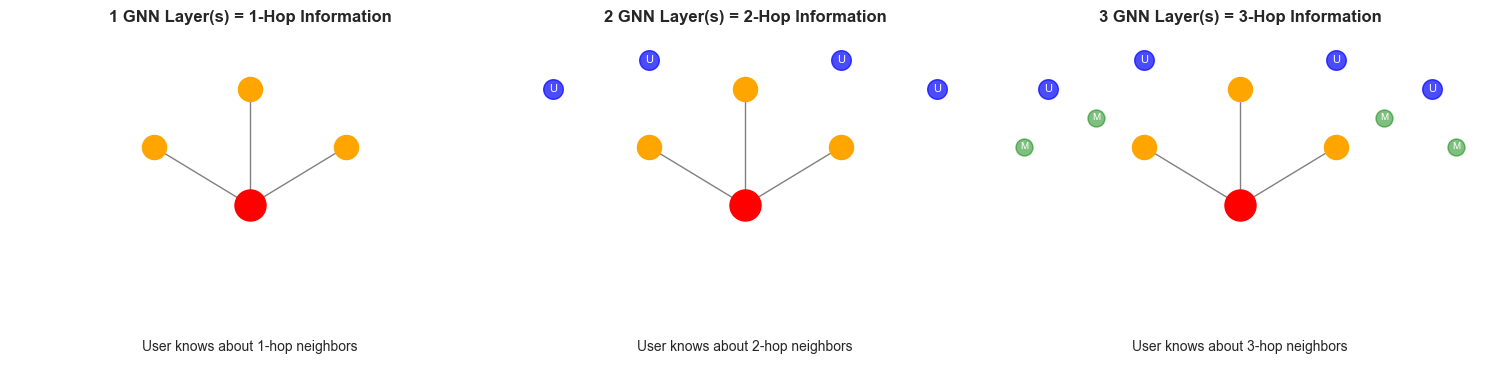

In [22]:
# Final visualization: How many layers = how many hops
def visualize_hops():
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, (ax, layers) in enumerate(zip(axes, [1, 2, 3])):
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 6)
        ax.axis('off')
        ax.set_title(f'{layers} GNN Layer(s) = {layers}-Hop Information', fontsize=12, fontweight='bold')
        
        # Central node
        ax.scatter([5], [3], s=500, c='red', zorder=10, label='Target User')
        ax.text(5, 3, 'U', ha='center', va='center', fontsize=12, color='white', fontweight='bold')
        
        if layers >= 1:
            # 1-hop neighbors (movies)
            for j, (x, y) in enumerate([(3, 4), (7, 4), (5, 5)]):
                ax.scatter([x], [y], s=300, c='orange', zorder=5)
                ax.text(x, y, 'M', ha='center', va='center', fontsize=10, color='white')
                ax.plot([5, x], [3, y], 'gray', linewidth=1, zorder=1)
        
        if layers >= 2:
            # 2-hop neighbors (other users)
            for x, y in [(1, 5), (3, 5.5), (7, 5.5), (9, 5)]:
                ax.scatter([x], [y], s=200, c='blue', alpha=0.7, zorder=3)
                ax.text(x, y, 'U', ha='center', va='center', fontsize=8, color='white')
        
        if layers >= 3:
            # 3-hop neighbors (their movies)
            for x, y in [(0.5, 4), (2, 4.5), (8, 4.5), (9.5, 4)]:
                ax.scatter([x], [y], s=150, c='green', alpha=0.5, zorder=2)
                ax.text(x, y, 'M', ha='center', va='center', fontsize=7, color='white')
        
        # Legend
        ax.text(5, 0.5, f'User knows about {layers}-hop neighbors', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("How GNN Layers Expand Information Flow:")
print("="*50)
visualize_hops()

---

## 🚀 Next Steps

Now that you understand the architectures:

0. **Run the GCN_Step_by_Step notebook**
1. Analyze the actual movie data. Use a small part of this data and see what happens inside GCN layer.
1. **Run the main learning notebook** (`GNN_Recommender_sİmple.ipynb`) to see these in action
2. **Experiment with layer counts** - try 1, 2, 3, 4 layers
3. **Compare embeddings** - visualize with t-SNE to see clustering
4. **Add node features** - incorporate movie genres for better cold-start handling